**Set up notebook:**

In [6]:
import sys
sys.path.append('../')
sys.path.append('../library/')
sys.path.append('../library/LogPai/')

In [7]:
#@title Import required libraries for this notebook
from library.malib import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

In [8]:
data_folder = 'Dataset/'

**Data preprocessing...**

**Load dataset:**

In [10]:
#Read WTG data
signals_train = 'wind-farm-1-signals-training.csv'
signals_test = 'wind-farm-1-signals-testing.csv'
all_data = load_data(data_folder=data_folder, file_name_1=signals_train, file_name_2=signals_test, time_index_column='Timestamp', delimeter=';')

#Read log data
logs_2016 = 'wind-farm-1-logs-2016.csv'
logs_2017 = 'wind-farm-1-logs-2017.csv'
log_data = load_data(data_folder=data_folder, file_name_1=logs_2016, file_name_2=logs_2017, time_index_column='TimeDetected', delimeter=';')
log_data = log_data.loc[log_data.index.notnull()]

#Target/Test turbine: Filter T_09 data out
T09_data = all_data[all_data.Turbine_ID == 'T09']
log_data_T09 = log_data[log_data['UnitTitle'] == 'T09']

#Reference/Validation turbine: Filter T_01 data out
T01_data = all_data[all_data.Turbine_ID == 'T01']
log_data_T01 = log_data[log_data['UnitTitle'] == 'T01']

#Remove duplicates in Timestamp index: Usually occurs at daylight saving
T09_data = T09_data[~T09_data.index.duplicated(keep='first')]
T01_data = T01_data[~T01_data.index.duplicated(keep='first')]

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/wind-farm-1-signals-training.csv'

**Extract log feature manually:**

In [4]:
feat_names_T01, log_feat_T01 = get_log_features(log_data_T01, 'Remark', 'vent\.')
feat_names_T09, log_feat_T09 = get_log_features(log_data_T09, 'Remark', 'vent\.')

/Users/backupuser/MA/library/malib.py:263: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  feats = feats[log_msg_column].str.rsplit('.', 1, expand=True).rename(columns = {0 : 'name', 1 : 'value'})
/Users/backupuser/MA/library/malib.py:263: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  feats = feats[log_msg_column].str.rsplit('.', 1, expand=True).rename(columns = {0 : 'name', 1 : 'value'})


**Extract log feature automatically using logpai:**

In [6]:
#logpai-parsed log features
input_dir  = '/Users/backupuser/MA/loglizer/logparser/logs/SCADA/' # The input directory of log file
output_dir = input_dir # The output directory of parsing results
log_file   = 'logs.txt' # The input log file name
log_format = '<TimeDetected>,<TimeReset>,<UnitTitle>,<Content>,<UnitTitleDestination>' # SCADA log format

logpai_feats_events_T01 = get_log_pai_feats('T01', 'EventId', data_folder_input=input_dir, data_folder_output=output_dir, 
log_file_name=log_file, log_format=log_format)
# logpai_feats_parameters_T01 = get_log_pai_feats('T01', 'ParameterList', data_folder_input=input_dir, data_folder_output=output_dir, 
# log_file_name=log_file, log_format=log_format)

logpai_feats_events_T09 = get_log_pai_feats('T09', 'EventId', data_folder_input=input_dir, data_folder_output=output_dir, 
log_file_name=log_file, log_format=log_format)
# logpai_feats_parameters_T09 = get_log_pai_feats('T09', 'ParameterList', data_folder_input=input_dir, data_folder_output=output_dir, 
# log_file_name=log_file, log_format=log_format)

NameError: name 'get_log_pai_feats' is not defined

**Append log features to signals:**

In [8]:
#Manual logs
T01_data_logs = pd.merge_asof(T01_data, log_feat_T01, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill')
T09_data_logs = pd.merge_asof(T09_data, log_feat_T09, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill')

In [9]:
#LogPai logs
T01_data_logs = pd.merge_asof(T01_data_logs, logpai_feats_events_T01, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill')
T09_data_logs = pd.merge_asof(T09_data_logs, logpai_feats_events_T09, left_index = True, right_index = True, tolerance = pd.Timedelta('10m')).fillna(method='ffill').fillna(method='bfill')

**EDA...**

In [666]:
#Selected features
#target_features = get_target_columns(T01_data_logs.columns, ['Gen', 'Temp'])
target_features = ['Gen_Bear_Temp_Avg']
#TODO: train on Gearbox temp (w/out log features and with logpai features)
features_wout_logs = ['Nac_Temp_Avg', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Prod_LatestAvg_TotActPwr'] + target_features
features_w_logs = features_wout_logs + feat_names_T01
features_w_logs_logpai = features_wout_logs + list(logpai_feats_events_T01.columns)
target_feature = 'Gen_Bear_Temp_Avg'


#Train/Test Periods
train_start_T09 = '2016-01-01'
train_end_T09 = '2016-02-15'
test_start_T09 = '2016-02-16'
test_end_T09 = '2016-10-18'

train_start_T01 = '2016-09-01'
train_end_T01 = '2016-09-30'
test_start_T01 = '2017-09-01'
test_end_T01 = '2017-12-31'

T09_data_logs.loc[train_start_T09 : train_end_T09, 'dataset'] = 'Train'
T09_data_logs.loc[test_start_T09 : test_end_T09, 'dataset'] = 'Test'

T01_data_logs.loc[train_start_T01 : train_end_T01, 'dataset'] = 'Train'
T01_data_logs.loc[test_start_T01 : test_end_T01, 'dataset'] = 'Test'

Distribution of Features (T01)

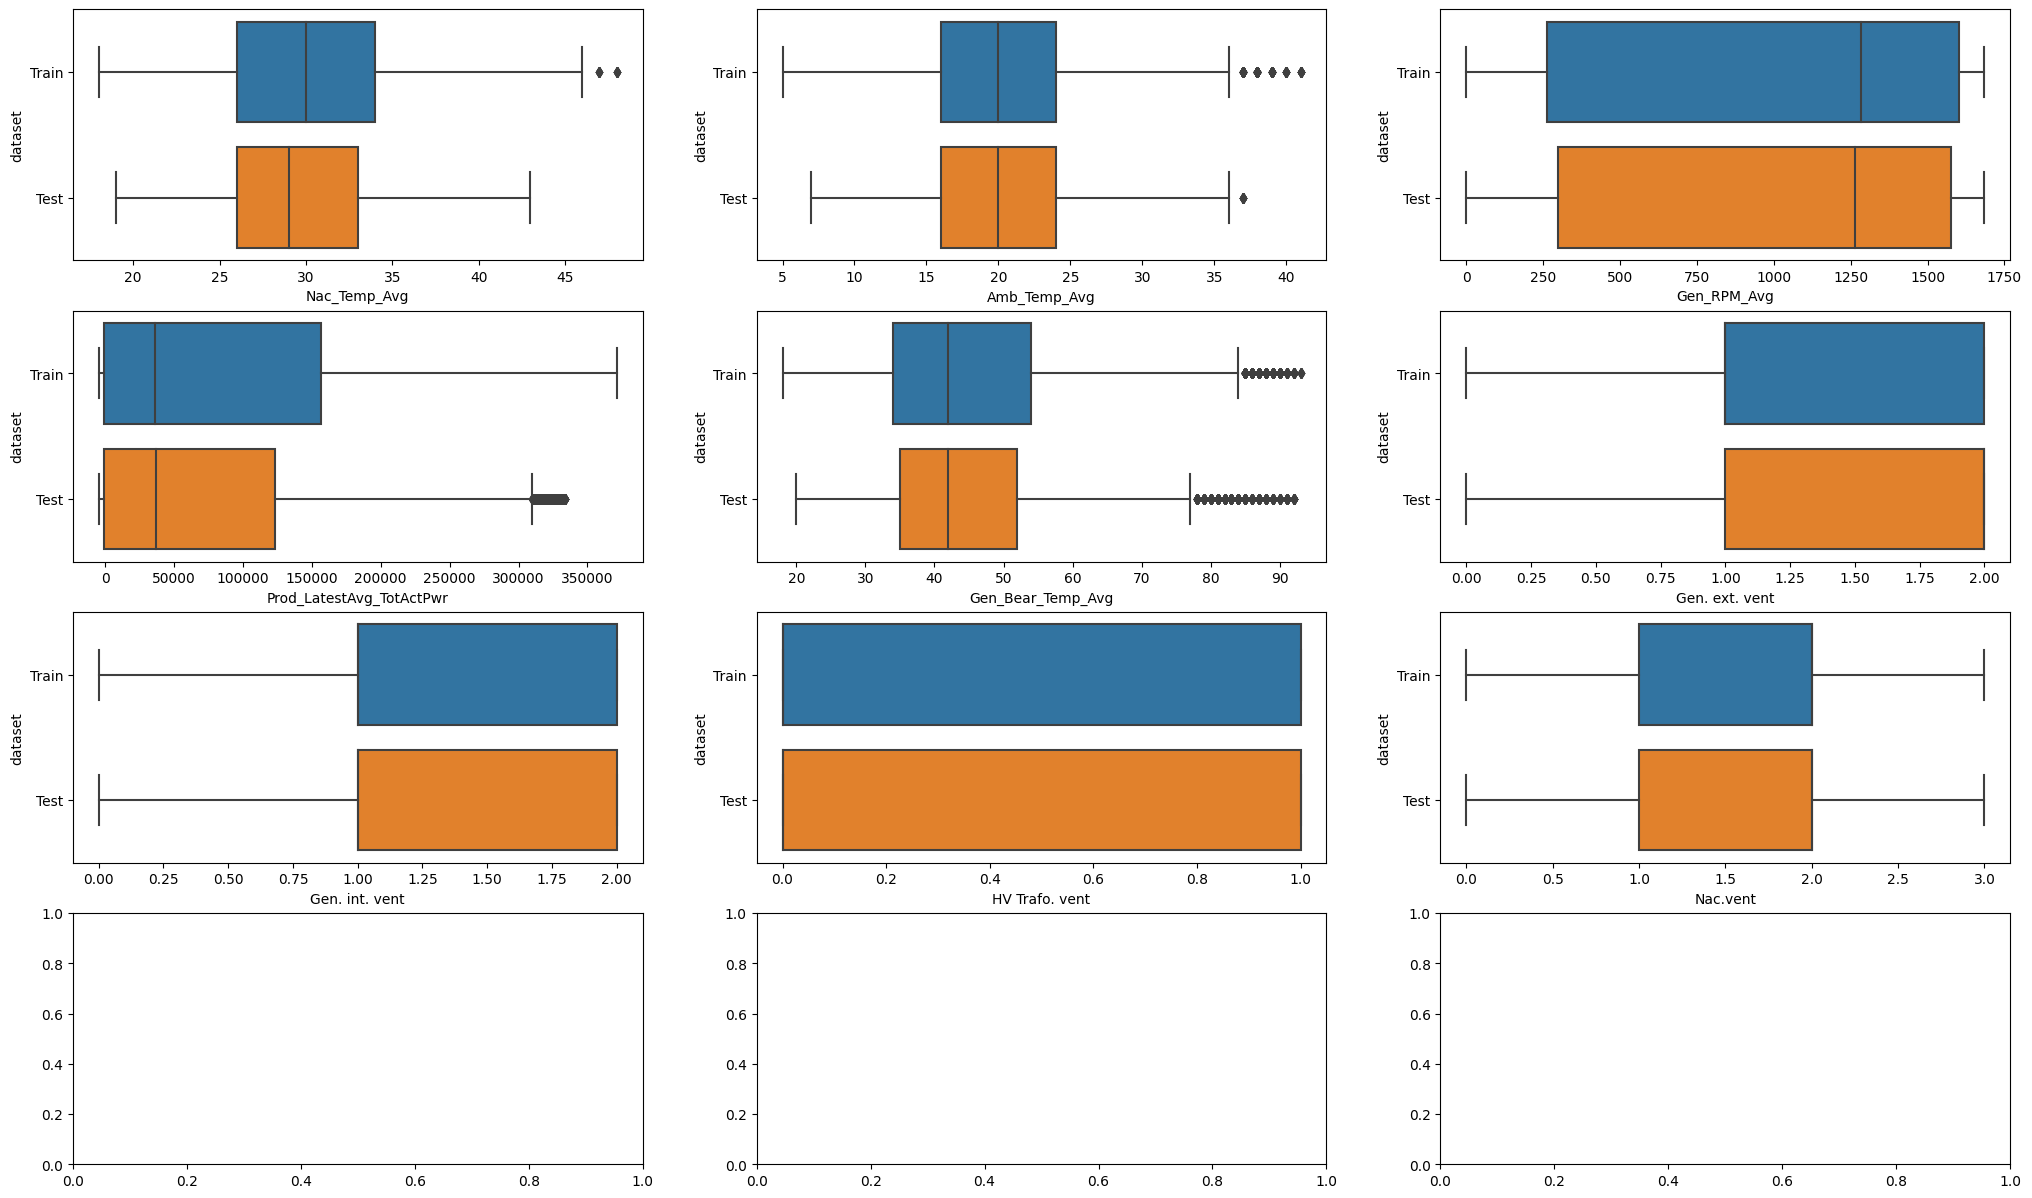

In [472]:
%matplotlib inline
fig, axes = plt.subplots((len(features_w_logs)//3) + 1, 3, figsize=(25,15))
for (i, feature) in zip(range(len(features_w_logs)), features_w_logs):
  sns.boxplot(data = T01_data_logs, x=feature, y='dataset', ax=axes[i//3][i%3])

Correlation of log features with target feature

In [32]:
# dic = [{'turbine' : 'T09', 
#         'Int_Vent' : T09_data_logs[train_start_T09 : train_end_T09][['Int_Vent']].corrwith(T09_data_logs[train_start_T09 : train_end_T09][target_feature])['Int_Vent'],
#         'Ext_Vent' : T09_data_logs[train_start_T09 : train_end_T09][['Ext_Vent']].corrwith(T09_data_logs[train_start_T09 : train_end_T09][target_feature])['Ext_Vent'],
#         'dataset' : 'Train'},
#        {'turbine' : 'T09', 
#         'Int_Vent' : T09_data_logs[test_start_T09 : test_end_T09][['Int_Vent']].corrwith(T09_data_logs[test_start_T09 : test_end_T09][target_feature])['Int_Vent'],
#         'Ext_Vent' : T09_data_logs[test_start_T09 : test_end_T09][['Ext_Vent']].corrwith(T09_data_logs[test_start_T09 : test_end_T09][target_feature])['Ext_Vent'],
#         'dataset' : 'Test'},
#        {'turbine' : 'T01', 
#         'Int_Vent' : T01_data_logs[train_start_T01 : train_end_T01][['Int_Vent']].corrwith(T01_data_logs[train_start_T01 : train_end_T01][target_feature])['Int_Vent'],
#         'Ext_Vent' : T01_data_logs[train_start_T01 : train_end_T01][['Ext_Vent']].corrwith(T01_data_logs[train_start_T01 : train_end_T01][target_feature])['Ext_Vent'],
#         'dataset' : 'Train'},
#        {'turbine' : 'T01', 
#         'Int_Vent' : T01_data_logs[test_start_T01 : test_end_T01][['Int_Vent']].corrwith(T01_data_logs[test_start_T01 : test_end_T01][target_feature])['Int_Vent'],
#         'Ext_Vent' : T01_data_logs[test_start_T01 : test_end_T01][['Ext_Vent']].corrwith(T01_data_logs[test_start_T01 : test_end_T01][target_feature])['Ext_Vent'],
#         'dataset' : 'Test'}]

# corr = pd.DataFrame(dic).set_index('turbine')
# corr

In [33]:
#====================================================================================================================================================

**NBM for T01(Healthy reference turbine)**

**Deep Learning**

In [670]:
#Train with log features (Manually-created logs) (single o/p)
dataset_1_s, X_train_1_s, Y_train_1_s, predictions_train_1_s, errors_train_1_s, X_test_1_s, Y_test_1_s, predictions_test_1_s, errors_test_1_s, model_1_s, scaler_input, scaler_target, rmse_train, rmse_test = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_w_logs, epochs=10, normalize=True);

Training model...
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 10)                90        
                                                                 
 dense_43 (Dense)            (None, 10)                110       
                                                                 
 dense_44 (Dense)            (None, 1)                 11        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
44/44 - 1s - loss: 0.4531 - 658ms/epoch - 15ms/step
Epoch 2/10
44/44 - 0s - loss: 0.2121 - 265ms/epoch - 6ms/step
Epoch 3/10
44/44 - 0s - loss: 0.1125 - 279ms/epoch - 6ms/step
Epoch 4/10
44/44 - 0s - loss: 0.0562 - 304ms/epoch - 7ms/step
Epoch 5/10
44/44 - 0s - loss: 0.0324 - 209ms/epoch -

ValueError: not enough values to unpack (expected 14, got 12)

In [474]:
#Train without log features (single o/p)
dataset_1_s_x, X_train_1_s_x, Y_train_1_s_x, predictions_train_1_s_x, errors_train_1_s_x, X_test_1_s_x, Y_test_1_s_x, predictions_test_1_s_x, errors_test_1_s_x, model_1_s_x, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 10)                50        
                                                                 
 dense_31 (Dense)            (None, 10)                110       
                                                                 
 dense_32 (Dense)            (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
521/521 - 3s - loss: 0.0096 - 3s/epoch - 5ms/step
Epoch 2/300
521/521 - 2s - loss: 0.0062 - 2s/epoch - 4ms/step
Epoch 3/300
521/521 - 2s - loss: 0.0060 - 2s/epoch - 4ms/step
Epoch 4/300
521/521 - 2s - loss: 0.0059 - 2s/epoch - 4ms/step
Epoch 5/300
521/521 - 2s - loss: 0.0058 - 2s/epoch - 

In [475]:
#Train with log features (logpai) (single o/p)
dataset_1_pai, X_train_1_pai, Y_train_1_pai, predictions_train_1_pai, errors_train_1_pai, X_test_1_pai, Y_test_1_pai, predictions_test_1_pai, errors_test_1_pai, model_1_pai, scaler_input, scaler_target = \
                        implement_pipeline_mlp(T01_data_logs, train_date_start = train_start_T01, train_date_end = train_end_T01,
                                           test_date_start = test_start_T01, test_date_end = test_end_T01, y_column = target_features, turbine_id='T01',
                         features=features_w_logs_logpai, epochs=300, normalize=True);

Training model...
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 10)                210       
                                                                 
 dense_34 (Dense)            (None, 10)                110       
                                                                 
 dense_35 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
521/521 - 3s - loss: 0.0199 - 3s/epoch - 6ms/step
Epoch 2/300
521/521 - 3s - loss: 0.0072 - 3s/epoch - 5ms/step
Epoch 3/300
521/521 - 3s - loss: 0.0066 - 3s/epoch - 6ms/step
Epoch 4/300
521/521 - 5s - loss: 0.0061 - 5s/epoch - 9ms/step
Epoch 5/300
521/521 - 5s - loss: 0.0059 - 5s/epoch - 

**NBM For T09 (Faulty turbine)**

In [23]:
#Train without log features (single o/p)
dataset_1_s_x_09, X_train_1_s_x_09, Y_train_1_s_x_09, predictions_train_1_s_x_09, errors_train_1_s_x_09, X_test_1_s_x_09, Y_test_1_s_x_09, predictions_test_1_s_x_09, errors_test_1_s_x_09, model_1_s_x_09, scaler_input_09, scaler_target_09 = \
                        implement_pipeline_mlp(T09_data_logs, train_date_start = train_start_T09, train_date_end = train_end_T09,
                                           test_date_start = test_start_T09, test_date_end = test_end_T09, y_column = target_features, turbine_id='T09',
                         features=features_wout_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                50        
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
67/67 - 1s - loss: 0.1561 - 857ms/epoch - 13ms/step
Epoch 2/300
67/67 - 0s - loss: 0.0357 - 442ms/epoch - 7ms/step
Epoch 3/300
67/67 - 0s - loss: 0.0290 - 447ms/epoch - 7ms/step
Epoch 4/300
67/67 - 0s - loss: 0.0245 - 388ms/epoch - 6ms/step
Epoch 5/300
67/67 - 0s - loss: 0.0215 - 390ms/epo

In [24]:
#Train with log features (logpai) (single o/p)
dataset_1_pai_09, X_train_1_pai_09, Y_train_1_pai_09, predictions_train_1_pai_09, errors_train_1_pai_09, X_test_1_pai_09, Y_test_1_pai_09, predictions_test_1_pai_09, errors_test_1_pai_09, model_1_pai_09, scaler_input_09, scaler_target_09 = \
                        implement_pipeline_mlp(T09_data_logs, train_date_start = train_start_T09, train_date_end = train_end_T09,
                                           test_date_start = test_start_T09, test_date_end = test_end_T09, y_column = target_features, turbine_id='T09',
                         features=features_w_logs_logpai, epochs=300, normalize=True);

Training model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 10)                210       
                                                                 
 dense_19 (Dense)            (None, 10)                110       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
67/67 - 1s - loss: 0.0578 - 778ms/epoch - 12ms/step
Epoch 2/300
67/67 - 0s - loss: 0.0331 - 373ms/epoch - 6ms/step
Epoch 3/300
67/67 - 0s - loss: 0.0232 - 366ms/epoch - 5ms/step
Epoch 4/300
67/67 - 0s - loss: 0.0216 - 374ms/epoch - 6ms/step
Epoch 5/300
67/67 - 0s - loss: 0.0193 - 364ms/epo

In [410]:
#Train with log features (manual) (single o/p)
dataset_1_logs_09, X_train_1_logs_09, Y_train_1_logs_09, predictions_train_1_logs_09, errors_train_1_logs_09, X_test_1_logs_09, Y_test_1_logs_09, predictions_test_1_logs_09, errors_test_1_logs_09, model_1_logs_09, scaler_input_09, scaler_target_09 = \
                        implement_pipeline_mlp(T09_data_logs, train_date_start = train_start_T09, train_date_end = train_end_T09,
                                           test_date_start = test_start_T09, test_date_end = test_end_T09, y_column = target_features, turbine_id='T09',
                         features=features_w_logs, epochs=300, normalize=True);

Training model...
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10)                90        
                                                                 
 dense_25 (Dense)            (None, 10)                110       
                                                                 
 dense_26 (Dense)            (None, 1)                 11        
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
67/67 - 1s - loss: 0.0209 - 683ms/epoch - 10ms/step
Epoch 2/300
67/67 - 0s - loss: 0.0173 - 326ms/epoch - 5ms/step
Epoch 3/300
67/67 - 0s - loss: 0.0167 - 274ms/epoch - 4ms/step
Epoch 4/300
67/67 - 0s - loss: 0.0164 - 350ms/epoch - 5ms/step
Epoch 5/300
67/67 - 0s - loss: 0.0161 - 322ms/epo

Distribution of errors

<AxesSubplot: xlabel='Gen_Bear_Temp_Avg', ylabel='Density'>

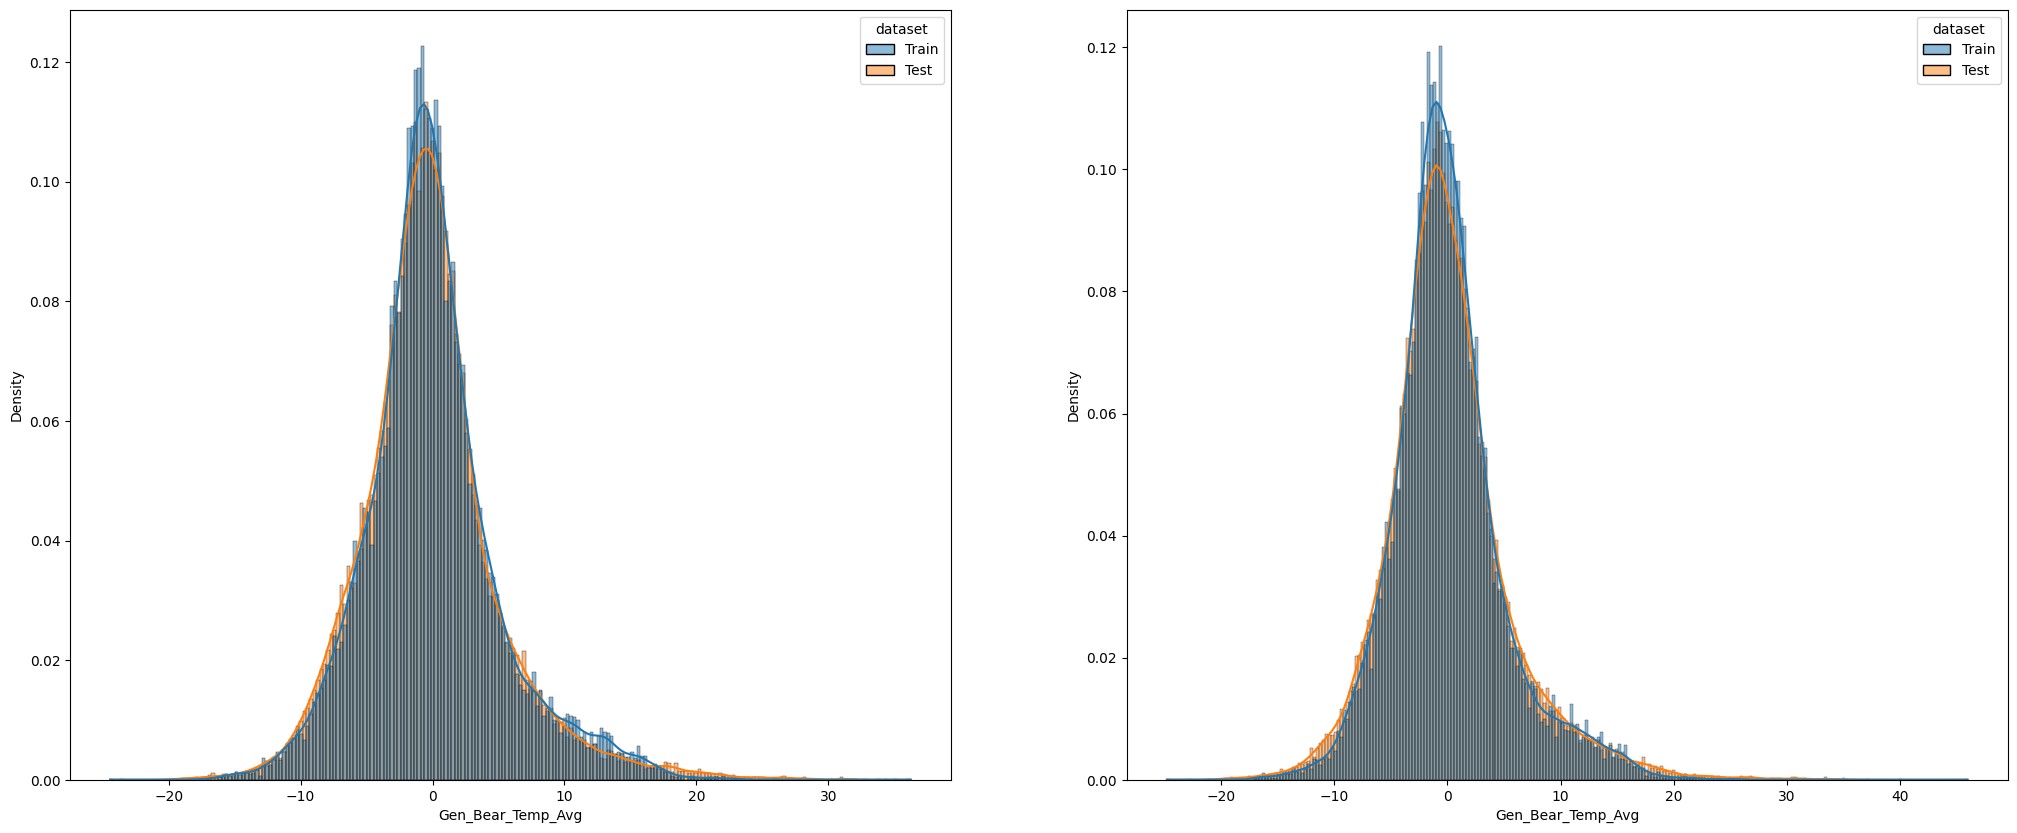

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(25,10))
errors_train_1_s_x['dataset'] = 'Train'
errors_test_1_s_x['dataset'] = 'Test'

errors_train_1_pai['dataset'] = 'Train'
errors_test_1_pai['dataset'] = 'Test'

sns.histplot(pd.concat([errors_train_1_s_x, errors_test_1_s_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[0])
sns.histplot(pd.concat([errors_train_1_pai, errors_test_1_pai], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[1])

# kl_logs = kl_divergence(np.histogram(errors_train_1_s_x[target_feature[0]], density=True)[0], np.histogram(errors_test_1_s[target_feature[0]], density=True)[0])
# kl_no_logs = kl_divergence(np.histogram(errors_train_1_pai[target_feature[0]], density=True)[0], np.histogram(errors_test_1_pai[target_feature[0]], density=True)[0])

# axes[0].set_title('Histogram of errors (with (manual) logs). KL div.: {}'.format(round(kl_logs, 4)));
# axes[1].set_title('Histogram of errors (with logpai logs). KL div.: {}'.format(round(kl_no_logs, 4)));

In [ ]:
# %matplotlib inline
# fig, axes = plt.subplots(len(target_features) + 1, 2, figsize=(25, 10 * (len(target_features) + 1)))
# errors_train_1['dataset'] = 'Train'
# errors_test_1['dataset'] = 'Test'

# errors_train_1_x['dataset'] = 'Train'
# errors_test_1_x['dataset'] = 'Test'

# #Create column to store total error
# errors_train_1['Total_Error'] = errors_train_1.sum(axis=1)
# errors_test_1['Total_Error'] = errors_test_1.sum(axis=1)

# errors_train_1_x['Total_Error'] = errors_train_1_x.sum(axis=1)
# errors_test_1_x['Total_Error'] = errors_test_1_x.sum(axis=1)

# for i, target_feature in enumerate(target_features + ['Total_Error']):

#   sns.histplot(pd.concat([errors_train_1, errors_test_1], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[i][0])
#   sns.histplot(pd.concat([errors_train_1_x, errors_test_1_x], ignore_index=True), x=target_feature, hue='dataset', kde=True, stat='density', common_norm=False, ax=axes[i][1])

#   kl_logs = kl_divergence(np.histogram(errors_train_1[target_feature], density=True)[0], np.histogram(errors_test_1[target_feature], density=True)[0])
#   kl_no_logs = kl_divergence(np.histogram(errors_train_1_x[target_feature], density=True)[0], np.histogram(errors_test_1_x[target_feature], density=True)[0])

#   axes[i][0].set_title('Histogram of errors (with logs). KL div.: {}'.format(round(kl_logs, 4)));
#   axes[i][1].set_title('Histogram of errors (without logs). KL div.: {}'.format(round(kl_no_logs, 4)));

In [ ]:
# #Multi vs single output
# fig, axes = plt.subplots(2, 2, figsize=(35,10))

# errors_train_1['model'] = 'Multi o/p'
# errors_test_1['model'] = 'Multi o/p'
# errors_train_1_x['model'] = 'Multi o/p'
# errors_test_1_x['model'] = 'Multi o/p'

# errors_train_1_s['model'] = 'Single o/p'
# errors_test_1_s['model'] = 'Single o/p'
# errors_train_1_s_x['model'] = 'Single o/p'
# errors_test_1_s_x['model'] = 'Single o/p'



# sns.histplot(pd.concat([errors_train_1, errors_train_1_s], ignore_index=True), x=target_feature[0], hue='model', kde=True, stat='density', common_norm=False, ax=axes[0][0])
# sns.histplot(pd.concat([errors_test_1, errors_test_1_s], ignore_index=True), x=target_feature[0], hue='model', kde=True, stat='density', common_norm=False, ax=axes[0][1])

# sns.histplot(pd.concat([errors_train_1_x, errors_train_1_s_x], ignore_index=True), x=target_feature[0], hue='model', kde=True, stat='density', common_norm=False, ax=axes[1][0])
# sns.histplot(pd.concat([errors_test_1_x, errors_test_1_s_x], ignore_index=True), x=target_feature[0], hue='model', kde=True, stat='density', common_norm=False, ax=axes[1][1])

# axes[0][0].set_title('Histogram of train errors (With logs).');
# axes[0][1].set_title('Histogram of test errors (With logs).');
# axes[1][0].set_title('Histogram of train errors (Without logs).');
# axes[1][1].set_title('Histogram of test errors (Without logs).');


Anomaly detection (assuming the error distribution is Gaussian for simplification)

**Healthy Turbine**

In [476]:
anomaly_threshold_x_01 = errors_train_1_s_x[target_feature].max()
anomaly_threshold_pai_01 = errors_train_1_pai[target_feature].max()
anomaly_threshold_logs_01 = errors_train_1_s[target_feature].max()

In [477]:
Y_test_1_s_x['Anomaly'] = errors_test_1_s_x[target_feature] > anomaly_threshold_x_01
Y_test_1_pai['Anomaly'] = errors_test_1_pai[target_feature] > anomaly_threshold_pai_01
Y_test_1_s['Anomaly'] = errors_test_1_s[target_feature] > anomaly_threshold_logs_01

In [496]:
errors_test_1_s_x[target_feature].max()

37.357421875

In [ ]:
n = 'quantile'
q = 0.99

n_x_1, Y_test_1_s_x = append_alarm_info(Y_test_1_s_x, n=n, q=q)
anomalies_x_1 = Y_test_1_s_x[Y_test_1_s_x['Anomaly']]

n_pai_1, Y_test_1_pai = append_alarm_info(Y_test_1_pai, n=n, q=q)
anomalies_pai_1 = Y_test_1_pai[Y_test_1_pai['Anomaly']]

n_logs_1, Y_test_1_s = append_alarm_info(Y_test_1_s, n=n, q=q)
anomalies_logs_1 = Y_test_1_s[Y_test_1_s['Anomaly']]

,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm
Timestamp,,,,,
2017-12-04 18:40:00+00:00,79.0,True,0.0,10,True
2017-12-04 18:50:00+00:00,78.0,True,0.0,11,True


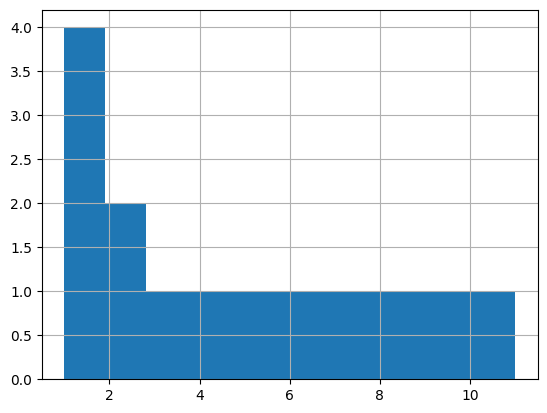

In [479]:
anomalies_x_1['n_Anomaly'].hist(bins=anomalies_x_1['n_Anomaly'].max() - anomalies_x_1['n_Anomaly'].min() + 1)
Y_test_1_s_x[Y_test_1_s_x.Alarm]

In [485]:
Y_test_1_pai['Anomaly']

Timestamp
2017-09-01 00:00:00+00:00    False
2017-09-01 00:10:00+00:00    False
2017-09-01 00:20:00+00:00    False
2017-09-01 00:30:00+00:00    False
2017-09-01 00:40:00+00:00    False
                             ...  
2017-12-31 23:10:00+00:00    False
2017-12-31 23:20:00+00:00    False
2017-12-31 23:30:00+00:00    False
2017-12-31 23:40:00+00:00    False
2017-12-31 23:50:00+00:00    False
Name: Anomaly, Length: 17532, dtype: bool

In [ ]:
anomalies_pai_1['n_Anomaly'].hist(bins=anomalies_pai_1['n_Anomaly'].max() - anomalies_pai_1['n_Anomaly'].min() + 1)
Y_test_1_pai[Y_test_1_pai.Alarm]

,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm
Timestamp,,,,,
2017-12-04 18:40:00+00:00,79.0,True,0.0,12,True
2017-12-04 18:50:00+00:00,78.0,True,0.0,13,True


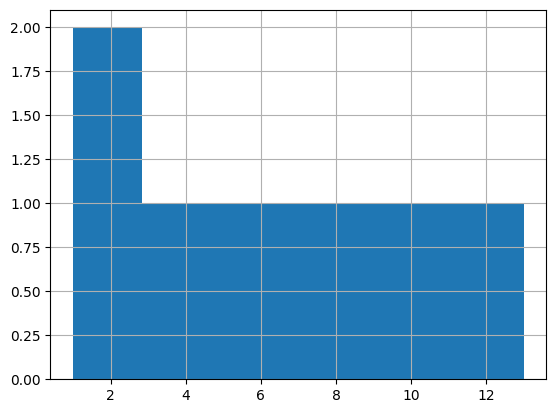

In [486]:
anomalies_logs_1['n_Anomaly'].hist(bins=anomalies_logs_1['n_Anomaly'].max() - anomalies_logs_1['n_Anomaly'].min() + 1)
Y_test_1_s[Y_test_1_s.Alarm]

**Faulty Turbine**

In [572]:
# anomaly_threshold_x_09_train = errors_train_1_s_x_09[target_feature].mean() + 3 * errors_train_1_s_x_09[target_feature].std()
# anomaly_threshold_pai_09_train = errors_train_1_pai_09[target_feature].max() + 3 * errors_train_1_pai_09[target_feature].std()
# anomaly_threshold_logs_09_train = errors_train_1_logs_09[target_feature].max() + 3 * errors_train_1_logs_09[target_feature].std()

In [640]:
anomaly_threshold_x_09_train = errors_train_1_s_x_09[target_feature].quantile(0.99)
anomaly_threshold_pai_09_train = errors_train_1_pai_09[target_feature].quantile(0.99)
anomaly_threshold_logs_09_train = errors_train_1_logs_09[target_feature].quantile(0.99)

In [641]:
Y_train_1_s_x_09['Anomaly'] = errors_train_1_s_x_09[target_feature] > anomaly_threshold_x_09_train
Y_train_1_pai_09['Anomaly'] = errors_train_1_pai_09[target_feature] > anomaly_threshold_pai_09_train
Y_train_1_logs_09['Anomaly'] = errors_train_1_logs_09[target_feature] > anomaly_threshold_logs_09_train

In [642]:
n = 'quantile'
#No alarms should be sent in train period
q = 1.0

n_x_train, Y_train_1_s_x_09 = append_alarm_info(Y_train_1_s_x_09, n=n, q=q)
anomalies_x_train = Y_train_1_s_x_09[Y_train_1_s_x_09['Anomaly']]

n_pai_train, Y_train_1_pai_09 = append_alarm_info(Y_train_1_pai_09, n=n, q=q)
anomalies_pai_train = Y_train_1_pai_09[Y_train_1_pai_09['Anomaly']]

n_logs_train, Y_train_1_logs_09 = append_alarm_info(Y_train_1_logs_09, n=n, q=q)
anomalies_logs_train = Y_train_1_logs_09[Y_train_1_logs_09['Anomaly']]

<ipython-input-544-b72a7df8bad4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']


In [643]:
anomaly_threshold_x_09_test = errors_train_1_s_x_09[target_feature].max()
anomaly_threshold_pai_09_test = errors_train_1_pai_09[target_feature].max()
anomaly_threshold_logs_09_test = errors_train_1_logs_09[target_feature].max()

In [644]:
Y_test_1_s_x_09['Anomaly'] = errors_test_1_s_x_09[target_feature] > anomaly_threshold_x_09_test
Y_test_1_pai_09['Anomaly'] = errors_test_1_pai_09[target_feature] > anomaly_threshold_pai_09_test
Y_test_1_logs_09['Anomaly'] = errors_test_1_logs_09[target_feature] > anomaly_threshold_logs_09_test

In [654]:
n_x_test, Y_test_1_s_x_09 = append_alarm_info(Y_test_1_s_x_09, n=n_x_train)
anomalies_x = Y_test_1_s_x_09[Y_test_1_s_x_09['Anomaly']]

n_pai_test, Y_test_1_pai_09 = append_alarm_info(Y_test_1_pai_09, n=n_pai_train)
anomalies_pai = Y_test_1_pai_09[Y_test_1_pai_09['Anomaly']]

n_logs_test, Y_test_1_logs_09 = append_alarm_info(Y_test_1_logs_09, n=n_logs_train)
anomalies_logs = Y_test_1_logs_09[Y_test_1_logs_09['Anomaly']]

<ipython-input-544-b72a7df8bad4>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_Anomaly'].iloc[i] = df.iloc[i-1]['n_Anomaly'] + 1 if row['Anomaly'] else df.iloc[i-1]['n_Anomaly']


In [655]:
Y_test_1_s_x_09 = append_relevant_log_warnings(Y_test_1_s_x_09, log_data_T09, 'Remark', target_feature, filter_by='Alarm', max_distance='24H')
Y_test_1_pai_09 = append_relevant_log_warnings(Y_test_1_pai_09, log_data_T09, 'Remark', target_feature, filter_by='Alarm', max_distance='24H')
Y_test_1_logs_09 = append_relevant_log_warnings(Y_test_1_logs_09, log_data_T09, 'Remark', target_feature, filter_by='Alarm', max_distance='24H')

,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm,logs_found
Timestamp,,,,,,


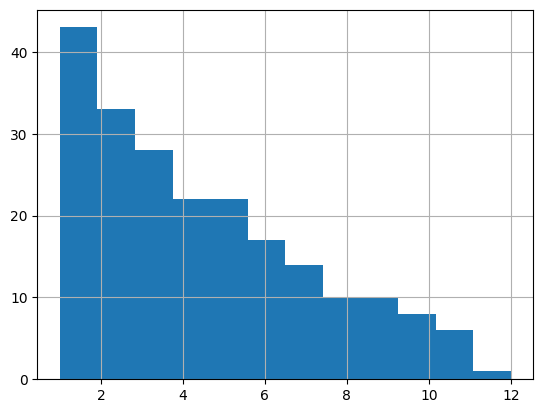

In [656]:
anomalies_x['n_Anomaly'].hist(bins=anomalies_x['n_Anomaly'].max() - anomalies_x['n_Anomaly'].min() + 1)
Y_test_1_s_x_09[Y_test_1_s_x_09.Alarm]

,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm,logs_found
Timestamp,,,,,,
2016-07-10 15:20:00+00:00,71.0,True,0.0,12,True,High temp. Gen bearing 1: 99°C @ 2016-07-09 17...


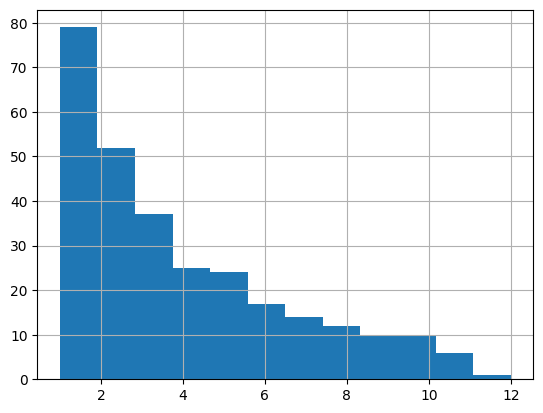

In [658]:
anomalies_pai['n_Anomaly'].hist(bins=anomalies_pai['n_Anomaly'].max() - anomalies_pai['n_Anomaly'].min() + 1)
Y_test_1_pai_09[Y_test_1_pai_09.Alarm]

In [664]:
log_data_T09[log_data_T09['Remark'].str.contains(target_feature.split('_Temp')[0].replace('_', ' '), na=False, case=False)]

,TimeReset,UnitTitle,Remark,UnitTitleDestination
TimeDetected,,,,
2016-06-07 16:58:42+00:00,07.06.16 18:54,T09,High temp. Gen bearing 1: 99°C,NaN
2016-06-21 14:45:57+00:00,21.06.16 14:50,T09,High temp. Gen bearing 1: 99°C,NaN
2016-06-21 16:20:39+00:00,21.06.16 16:33,T09,High temp. Gen bearing 1: 99°C,NaN
2016-06-21 17:58:34+00:00,21.06.16 18:30,T09,High temp. Gen bearing 1: 99°C,NaN
2016-06-22 15:01:24+00:00,22.06.16 17:09,T09,High temp. Gen bearing 1: 99°C,NaN
2016-07-03 15:57:13+00:00,03.07.16 16:02,T09,High temp. Gen bearing 1: 99°C,NaN
2016-07-03 17:10:13+00:00,03.07.16 17:51,T09,High temp. Gen bearing 1: 99°C,NaN
2016-07-03 20:21:40+00:00,03.07.16 21:23,T09,High temp. Gen bearing 1: 99°C,NaN
2016-07-09 17:10:00+00:00,09.07.16 20:23,T09,High temp. Gen bearing 1: 99°C,NaN


,Gen_Bear_Temp_Avg,Anomaly,Diff_in_days,n_Anomaly,Alarm,logs_found
Timestamp,,,,,,
2016-07-03 21:10:00+00:00,78.0,True,0.0,12,True,High temp. Gen bearing 1: 99°C @ 2016-07-03 15...
2016-07-03 21:20:00+00:00,73.0,True,0.0,13,True,High temp. Gen bearing 1: 99°C @ 2016-07-03 15...
2016-07-10 07:00:00+00:00,63.0,True,0.0,12,True,High temp. Gen bearing 1: 99°C @ 2016-07-09 17...
2016-07-10 15:00:00+00:00,81.0,True,0.0,13,True,High temp. Gen bearing 1: 99°C @ 2016-07-09 17...
2016-07-10 15:10:00+00:00,76.0,True,0.0,14,True,High temp. Gen bearing 1: 99°C @ 2016-07-09 17...
2016-07-10 15:20:00+00:00,71.0,True,0.0,15,True,High temp. Gen bearing 1: 99°C @ 2016-07-09 17...
2016-07-10 15:30:00+00:00,67.0,True,0.0,16,True,High temp. Gen bearing 1: 99°C @ 2016-07-09 17...
2016-07-10 15:40:00+00:00,64.0,True,0.0,17,True,High temp. Gen bearing 1: 99°C @ 2016-07-09 17...
2016-07-10 15:50:00+00:00,61.0,True,0.0,18,True,High temp. Gen bearing 1: 99°C @ 2016-07-09 17...


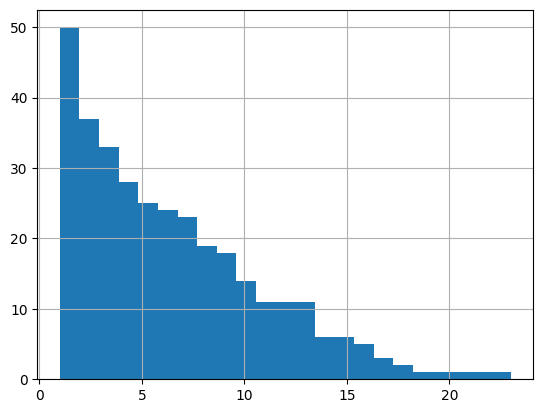

In [659]:
anomalies_logs['n_Anomaly'].hist(bins=anomalies_logs['n_Anomaly'].max() - anomalies_logs['n_Anomaly'].min() + 1)
Y_test_1_logs_09[Y_test_1_logs_09.Alarm]

In [444]:
y, x = np.histogram(anomalies_pai['n_Anomaly'], bins=anomalies_pai['n_Anomaly'].max() - anomalies_pai['n_Anomaly'].min() + 1)

In [445]:
b, a = np.polyfit(x[:-1], np.log(y), 1)

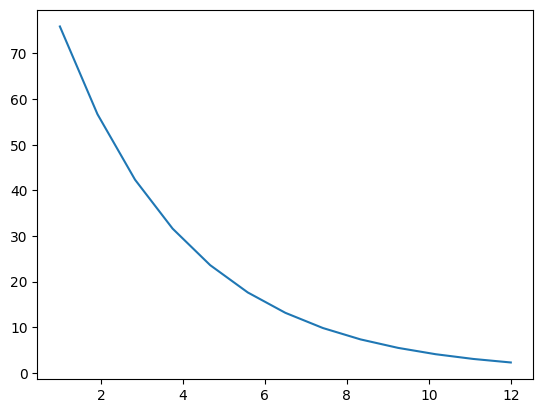

In [446]:
plt.plot(x, np.exp(a) * np.exp(b * x))

In [186]:
anomaly_thresholds_1 = [errors_train_1[target_feature].mean() + 3 * errors_train_1[target_feature].std() for target_feature in target_features]
booleans_train_1 = errors_train_1[target_features] > anomaly_thresholds_1
booleans_test_1 = errors_test_1[target_features] > anomaly_thresholds_1  

anomaly_thresholds_1_x = [errors_train_1_x[target_feature].mean() + 3 * errors_train_1_x[target_feature].std() for target_feature in target_features]
booleans_train_1_x = errors_train_1_x[target_features] > anomaly_thresholds_1_x
booleans_test_1_x = errors_test_1_x[target_features] > anomaly_thresholds_1_x

#System Anomaly if model detected an anomaly for ANY of the target features
Y_test_1['Anomaly_Any'] = booleans_test_1.apply(any, axis=1)
Y_train_1['Anomaly_Any'] = booleans_train_1.apply(any, axis=1)

Y_test_1_x['Anomaly_Any'] = booleans_test_1_x.apply(any, axis=1)
Y_train_1_x['Anomaly_Any'] = booleans_train_1_x.apply(any, axis=1)

#System Anomaly if model detected an anomaly for ALL of the target features
Y_test_1['Anomaly_All'] = booleans_test_1.apply(all, axis=1)
Y_train_1['Anomaly_All'] = booleans_train_1.apply(all, axis=1)

Y_test_1_x['Anomaly_All'] = booleans_test_1_x.apply(all, axis=1)
Y_train_1_x['Anomaly_All'] = booleans_train_1_x.apply(all, axis=1)

#System Anomaly if model detected an anomaly in the total error
anomaly_threshold_total_1 = errors_train_1['Total_Error'].mean() + 3 * errors_train_1['Total_Error'].std()
Y_test_1['Anomaly_Total'] = errors_test_1['Total_Error'] > anomaly_threshold_total_1
Y_train_1['Anomaly_Total'] = errors_train_1['Total_Error'] > anomaly_threshold_total_1

anomaly_threshold_total_1_x = errors_train_1_x['Total_Error'].mean() + 3 * errors_train_1_x['Total_Error'].std()
Y_test_1_x['Anomaly_Total'] = errors_test_1_x['Total_Error'] > anomaly_threshold_total_1_x
Y_train_1_x['Anomaly_Total'] = errors_train_1_x['Total_Error'] > anomaly_threshold_total_1_x

print('Anomaly thresholds (using log feature): ', anomaly_thresholds_1)
print('Anomaly thresholds (not using log feature): ', anomaly_thresholds_1_x)

Anomaly thresholds (using log feature):  [13.44035281255635, 14.930872608040382, 14.588857224884535, 14.492159172259486, 4.599813627299309, 15.18476239434166]
Anomaly thresholds (not using log feature):  [13.880517498752768, 16.20272564578246, 16.026773581766385, 15.581226284865867, 4.162055885222559, 15.988314956951687]


In [117]:
#Normalized errors
for column, threshold in zip (errors_train_1.columns, anomaly_thresholds_1):
    errors_train_1['Normalized_' + column] = errors_train_1[column] / threshold

for column, threshold in zip (errors_train_1_x.columns, anomaly_thresholds_1_x):
    errors_train_1_x['Normalized_' + column] = errors_train_1_x[column] / threshold

for column, threshold in zip (errors_test_1.columns, anomaly_thresholds_1):
    errors_test_1['Normalized_' + column] = errors_test_1[column] / threshold

for column, threshold in zip (errors_test_1_x.columns, anomaly_thresholds_1_x):
    errors_test_1_x['Normalized_' + column] = errors_test_1_x[column] / threshold

In [ ]:
errors_train_1['log_ft'] = 'With Logs'
errors_train_1_x['log_ft'] = 'Without Logs'

errors_test_1['log_ft'] = 'With Logs'
errors_test_1_x['log_ft'] = 'Without Logs'



In [119]:
#Add date column
Y_test_1['date'] = pd.to_datetime(Y_test_1.index.date)
Y_test_1_x['date'] = pd.to_datetime(Y_test_1_x.index.date)

Extract days where at least one anomaly was detected to visualize data

In [130]:
#gt -> ground truth, pr -> predictions, x -> input features
gt_1 = Y_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly_All']].index.date))].reset_index()
pr_1 = predictions_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly_All']].index.date))].reset_index()
x_1 = X_test_1[Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly_All']].index.date))].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_features] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_features] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

All anomalies detected by model_1 (NBM with log features) (click on img to zoom)

In [187]:
#indices = Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly_All']].index.date))
indices = (Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly_All']].index.date))) & \
         ~(Y_test_1.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly_All']].index.date)))

In [197]:
data.shape[0]//len(data.cols.unique())//2

576

KeyError: "['Anomaly_All'] not in index"

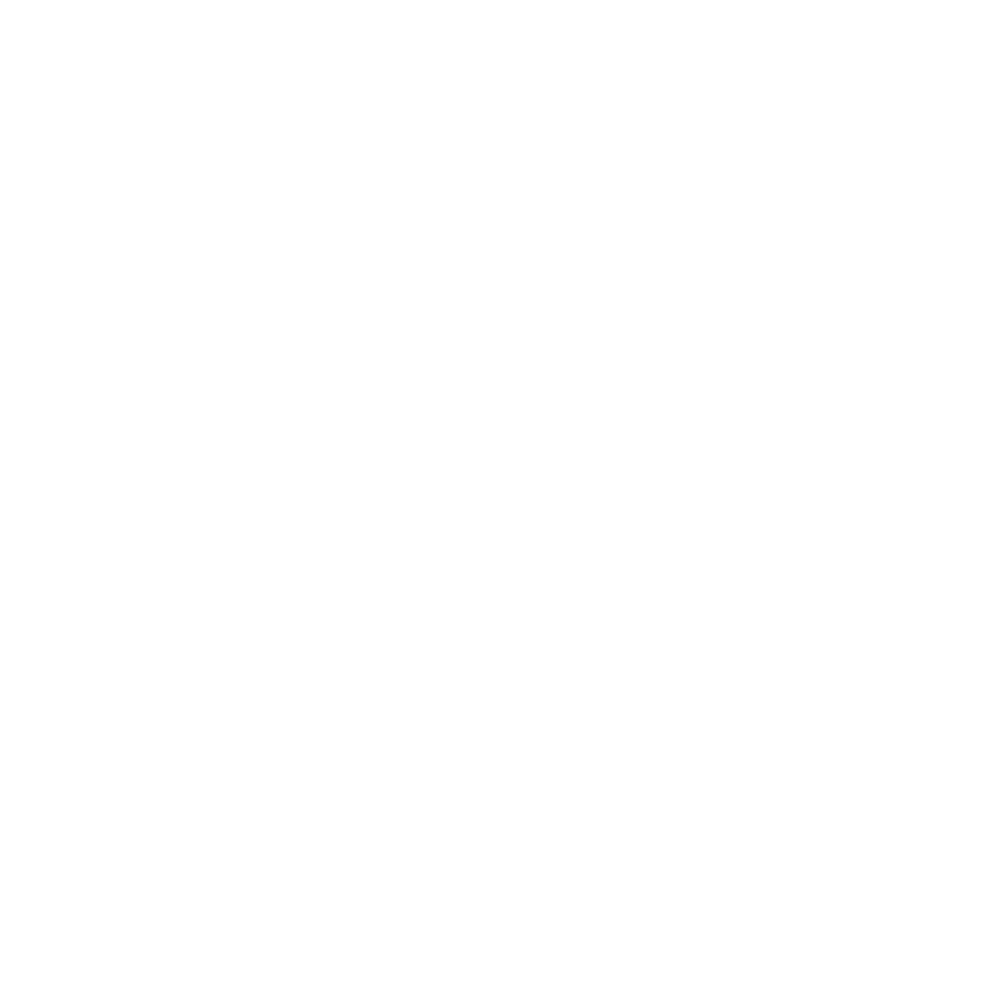

In [202]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
normalized_columns = [column for column in errors_test_1.columns if column.startswith('Normalized')]
data = pd.concat([errors_test_1[indices][normalized_columns + ['Anomaly_All', 'log_ft']].reset_index().reset_index(), 
errors_test_1_x[indices][normalized_columns + ['Anomaly_All', 'log_ft']].reset_index().reset_index()], ignore_index=True).rename(
    columns={'index' : 'fake_index'}
).melt(
    ['log_ft', 'Timestamp', 'fake_index', 'Anomaly_All'], var_name='cols', value_name='vals')

ax = sns.lineplot(data=data, x='fake_index', y='vals', hue='cols', style='log_ft')


plt.xticks(range(0, len(data.fake_index.unique()), 72), 
labels = data['Timestamp'].unique()[:-1:72], rotation=320);
plt.grid(False);

plt.axhline(y=1.0)
for index in data[data.Anomaly_All].fake_index:
    plt.axvline(x=index, style='--')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_1 (NBM with log features) and not by model_1_x (NBM without log features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


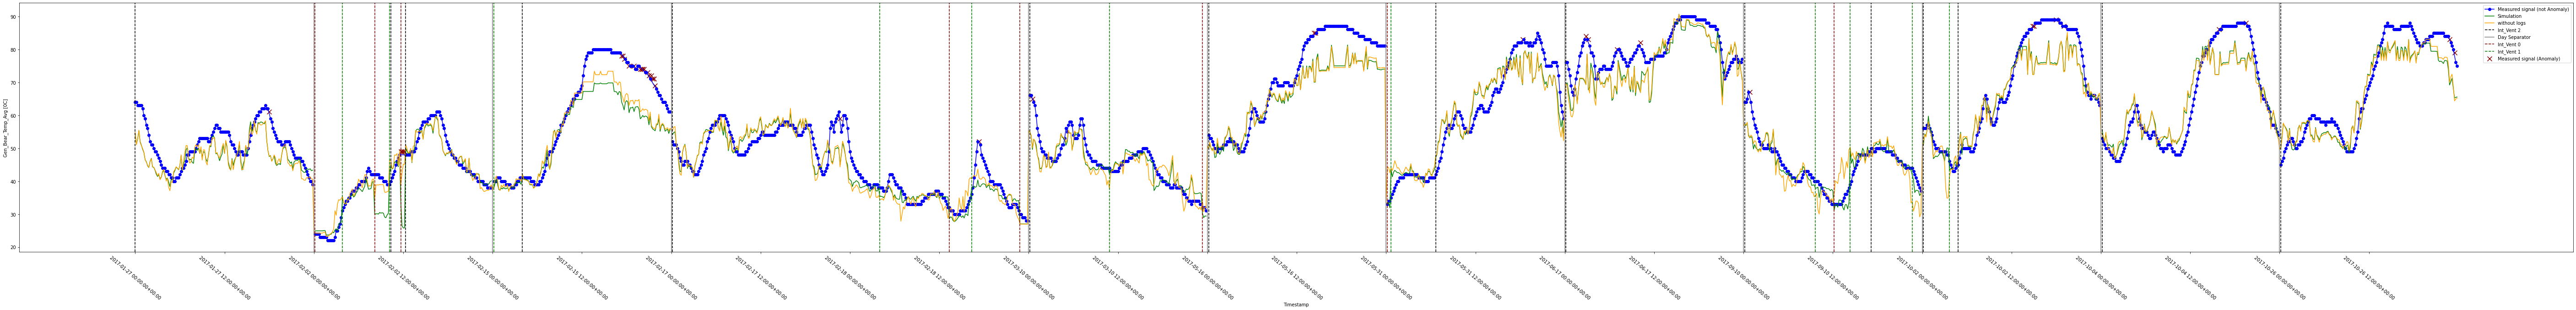

In [ ]:
ixes = (Y_test_1.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date))) & ~(Y_test_1.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly']].index.date)))

gt_1 = Y_test_1[ixes].reset_index()
pr_1 = predictions_test_1[ixes].reset_index()
x_1 = X_test_1[ixes].reset_index()

pr_1_x = predictions_test_1_x[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1.loc[gt_1['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1.loc[x_1['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_1, gt_1, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_1_x.index, pr_1_x[target_feature], color='orange', label='without logs')
plot_control_signals(x_1, 'Int_Vent')

plt.xticks(range(0, gt_1.shape[0], 72), labels = gt_1['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

Anomalies detected by model_1_x (NBM without log features) and not by model_1 (NBM with log features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


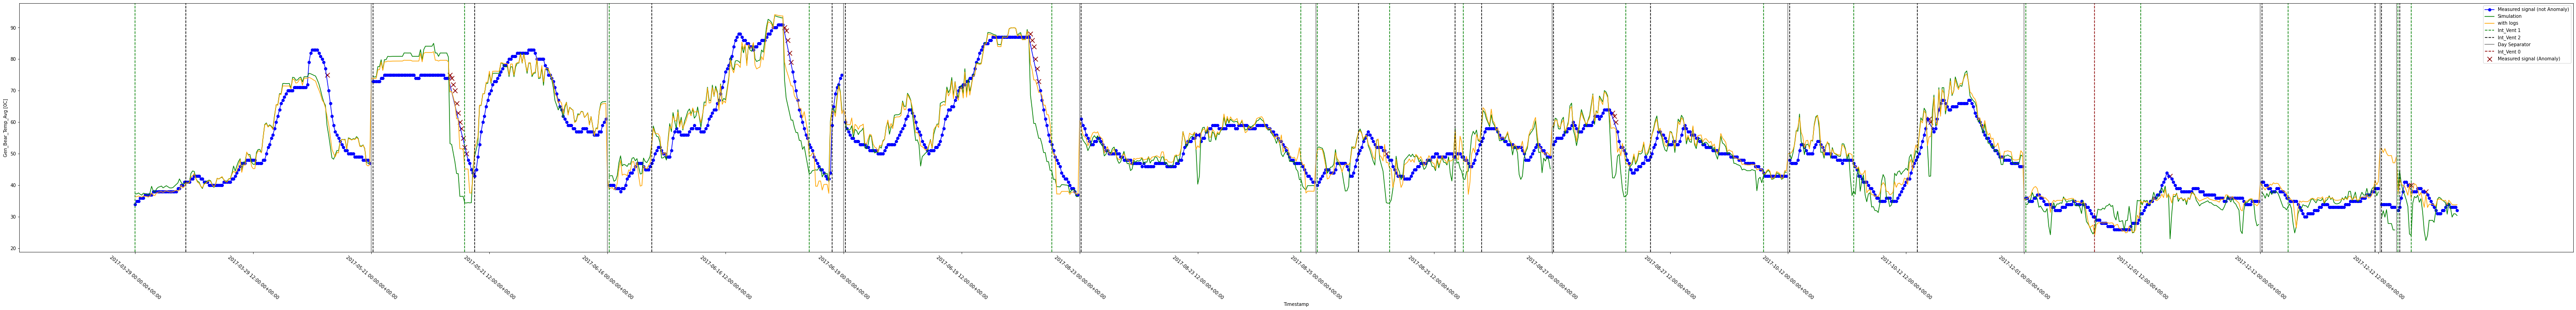

In [ ]:
ixes = (Y_test_1_x.date.isin(list(Y_test_1_x[Y_test_1_x['Anomaly']].index.date))) & ~(Y_test_1_x.date.isin(list(Y_test_1[Y_test_1['Anomaly']].index.date)))

gt_1_x = Y_test_1_x[ixes].reset_index()
pr_1_x = predictions_test_1_x[ixes].reset_index()
x_1_x = X_test_1[ixes].reset_index()

pr_1 = predictions_test_1[ixes].reset_index()

#Add NANs between every two non-consecutive days to be visualized as a gap
gt_1_x.loc[gt_1_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
pr_1_x.loc[gt_1_x['Timestamp'].diff().dt.total_seconds() > 600, target_feature] = np.NAN
x_1_x.loc[x_1_x['Timestamp'].diff().dt.total_seconds() > 600, 'Int_Vent'] = np.NAN

plot_predicted_vs_true(pr_1_x, gt_1_x, target_feature, hue='Anomaly', figsize=(100,10))
plt.plot(pr_1.index, pr_1[target_feature], color='orange', label='with logs')
plot_control_signals(x_1_x, 'Int_Vent')

plt.xticks(range(0, gt_1_x.shape[0], 72), labels = gt_1_x['Timestamp'][:-1:72], rotation=320);
plt.grid(False);

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());